# Distillation modeling & design

Distillation is the most widely used unit operation in the chemical industry, with applications in petrochemicals, pharmaceuticals, and biorefining. For the separation of almost any mixture, distillation may be a viable option. Because of this, new separation technologies (e.g., membrane, adsorption) are often compared against distillation-based processes. In this tutorial, we will design and simulate distillation columns for separating hydrocarbons and purifying small organic molecules.

## Shortcut distillation models

Distillation is a complex unit to model. Given M stages and N chemicals, we get M * (3 * N + 1) nonlinear and highly coupled equations for material, energy, and phase equilibria. Optimizing a distillation column is even more challenging. As a start, we can use "shortcut" methods which use simplifying assumptions to design and model a distillation column. Two common shortcut methods include the McCabe-Thiele methods for binary (2-component) distillation and the Fenske-Underwood-Gilliland method for multicomponent distillation. These methods can be surprisingly accurate (in some cases) and are often used for agile analyses where high-fidelity is not required.

### Binary distillation with McCabe-Thiele

The McCabe-Thiele method assumes that for every mole of liquid vaporized, a mole of vapor is condensed (i.e., constant molar overflow). For a two-component system under this assumption, each stage can be solved sequentially using a bubble/dew point calculation and a simple mass balance. This assumption can be relatively good for components with similar heats of vaporitation.

In BioSTEAM, we extend the McCabe-Thiele method for 3 or more componets by assuming that chemicals which are more volatile than the light key will partition to the distillate while chemicals which are heavier than the heavy key will partition to the bottoms product. This can be a good assumption if the non-key chemicals are present in trace amounts.  

Let's model a distillation column for separating ethanol from beer (e.g., from fermenting ethanol):

In [1]:
import biosteam as bst
import numpy as np
bst.nbtutorial()

# First set the property package
bst.settings.set_thermo(['Water', 'Ethanol', 'Glycerol', 'Yeast'], db='BioSTEAM')

# Create the feed at the bubble point
feed = bst.Stream(
    'feed', 
    Water=1.08e+03, 
    Ethanol=586,
    Glycerol=10,
    Yeast=50,
    units='kg/hr',
)
feed.vle(V=0, P=101325)

# Create distillation column
McCabeThiele = bst.BinaryDistillation(
    'McCabeThiele', ins=feed,
    outs=('distillate', 'bottoms_product'),
    LHK=('Ethanol', 'Water'), # Light and heavy keys
    y_top=0.79, # Light key composition at the distillate
    x_bot=0.001, # Light key composition at the bottoms product
    k=1.25, # Ratio of actual reflux over minimum reflux
    is_divided=True, # Whether the rectifying and stripping sections are divided
)
McCabeThiele.simulate()
McCabeThiele.diagram()
McCabeThiele.show()

BinaryDistillation: McCabeThiele
ins...
[0] feed  
    phases: ('g', 'l'), T: 356.95 K, P: 101325 Pa
    flow (kmol/hr): (l) Water     59.9
                        Ethanol   12.7
                        Glycerol  0.109
                        Yeast     2.21
outs...
[0] distillate  
    phase: 'g', T: 351.63 K, P: 101325 Pa
    flow (kmol/hr): Water    3.37
                    Ethanol  12.7
[1] bottoms_product  
    phase: 'l', T: 372.85 K, P: 101325 Pa
    flow (kmol/hr): Water     56.6
                    Ethanol   0.0566
                    Glycerol  0.109
                    Yeast     2.21


In [2]:
McCabeThiele.results()

Divided Distillation Column                                Units  McCabeThiele
Electricity         Power                                     kW         0.139
                    Cost                                  USD/hr        0.0109
Cooling water       Duty                                   kJ/hr     -6.37e+05
                    Flow                                 kmol/hr           435
                    Cost                                  USD/hr         0.212
Low pressure steam  Duty                                   kJ/hr       1.4e+06
                    Flow                                 kmol/hr          36.3
                    Cost                                  USD/hr          8.63
Design              Theoretical feed stage                                  24
                    Theoretical stages                                      29
                    Minimum reflux                         Ratio           0.8
                    Reflux                                 Ratio             1
                    Rectifier stages                                        41
                    Stripper stages                                         10
                    Rectifier height                          ft            73
                    Stripper height                           ft          27.3
                    Rectifier diameter                        ft             3
                    Stripper diameter                         ft             3
                    Rectifier wall thickness                  in           0.5
                    Stripper wall thickness                   in         0.312
                    Rectifier weight                          lb      9.16e+03
                    Stripper weight                           lb       3.6e+03
Purchase cost       Rectifier trays                          USD      2.92e+04
                    Stripper trays                           USD      1.03e+04
                    Rectifier tower                          USD      5.86e+04
                    Stripper platform and ladders            USD      2.13e+04
                    Stripper tower                           USD      3.41e+04
                    Rectifier platform and ladders           USD      9.69e+03
                    Condenser - Double pipe                  USD      5.19e+03
                    Reflux drum - Vertical pressure ...      USD      7.58e+03
                    Reflux drum - Platform and ladders       USD      1.85e+03
                    Pump - Pump                              USD      4.36e+03
                    Pump - Motor                             USD           141
                    Reboiler - Double pipe                   USD       5.2e+03
Total purchase cost                                          USD      1.88e+05
Utility cost                                              USD/hr          8.85

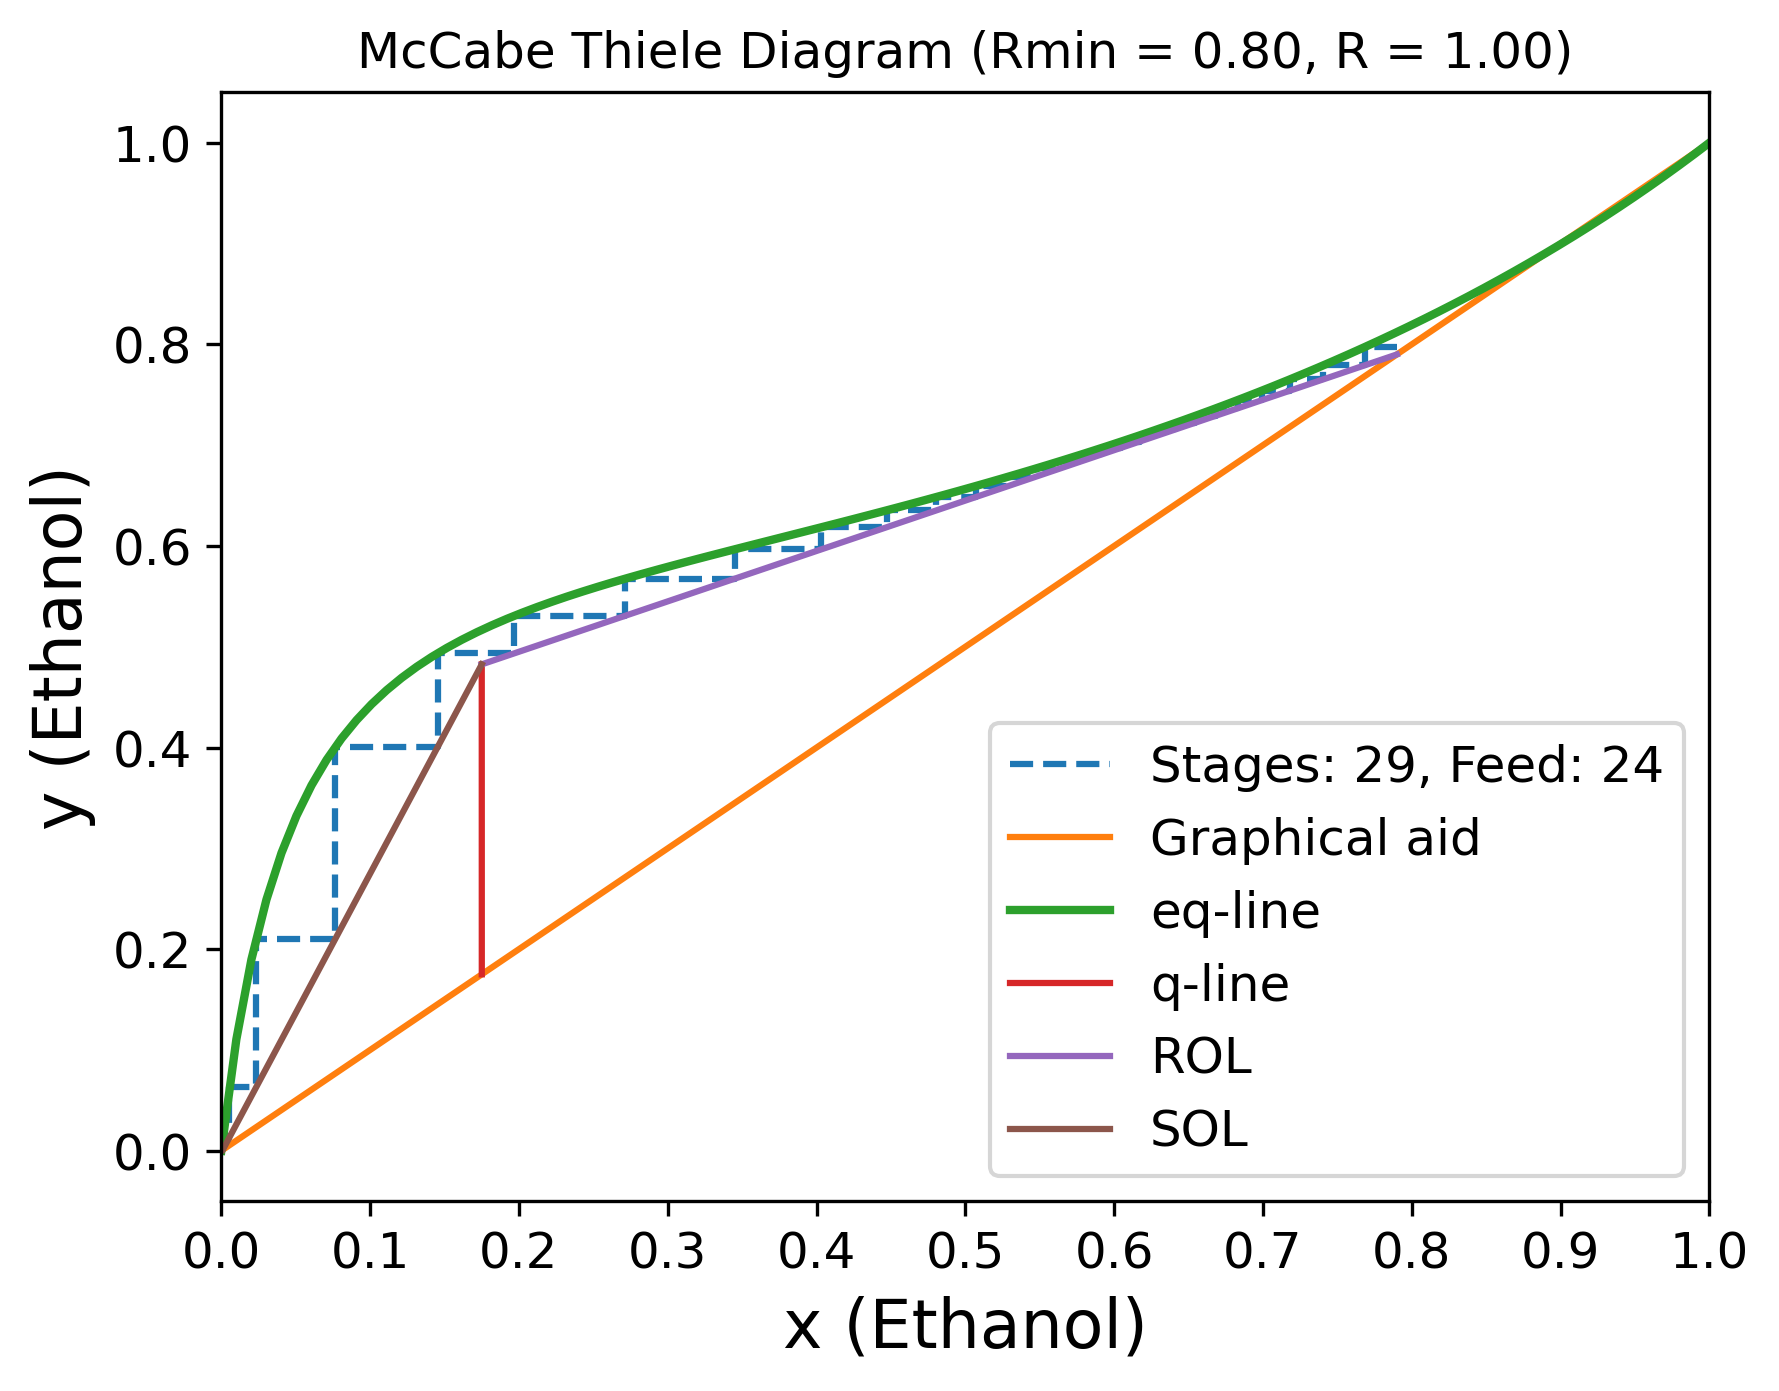

<module 'matplotlib.pyplot' from 'C:\\Users\\yoelr\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

In [3]:
McCabeThiele.plot_stages()

### Multicomponent distillation with Fenske-Underwood-Gilliland

The Fenske-Underwood-Gilliland assumes a constant molar overflow and an average relative volatility across stages to allow for multicomponent distillation. This method can give reasonable estimates when volatilities are "well behaved" across stages and the latent heats between chemicals are similar. However, it will give completely unreasonable results when azeotropes are present. Let's use this shortcut method to model the separation of a hydrocarbon mixture into -C5 and C6+ fraction.

In [4]:
hydrocarbons = [
    'Ethane', 'Propane', 'n-Butane', 
    'n-Pentane', 'n-Hexane', 'n-Heptane', 
    'Cyclohexane', 'Cycloheptane', 'Benzene',
    'Toluene', 'Hydrogen'
]
bst.settings.set_thermo(hydrocarbons, pkg='Peng Robinson')
feed = bst.Stream('feed',)
feed.imol[hydrocarbons] = 242.6 * np.array([
    7.54105070e-10, 2.56035674e-06, 5.34074413e-03, 
    1.850257e-01, 3.06487804e-01, 1.27207300e-01, 
    3.97638023e-02, 6.96044980e-04, 3.35385551e-01,
    9.04125972e-05, 1.00013935e-18
])
feed.vle(T=340.3, P=366463)
FUG = bst.ShortcutColumn(
    'FUG',
    ins=[feed],
    outs=['distillate', 'bottoms_product'],
    LHK=['Cyclohexane', 'n-Heptane'],
    P=feed.P,
    Lr=0.98, # Light key recovery
    Hr=0.98, # Heavy key recovery
    k=1.25 # Reflux to minimum reflux
)
FUG.simulate()
FUG.show('cmol100')

ShortcutColumn: FUG
ins...
[0] feed  
    phases: ('g', 'l'), T: 340.3 K, P: 366463 Pa
    composition (%): (l) Ethane        7.54e-08
                         Propane       0.000256
                         n-Butane      0.534
                         n-Pentane     18.5
                         n-Hexane      30.6
                         n-Heptane     12.7
                         Cyclohexane   3.98
                         Cycloheptane  0.0696
                         Benzene       33.5
                         Toluene       0.00904
                         Hydrogen      1e-16
                         ------------  243 kmol/hr
outs...
[0] distillate  
    phase: 'g', T: 401.49 K, P: 366463 Pa
    composition (%): n-Pentane     21.4
                     n-Hexane      35.5
                     n-Heptane     0.294
                     Cyclohexane   4.51
                     Cycloheptane  3.31e-08
                     Benzene       38.3
                     Toluene       2.47e-07
       

## Rigorous distillation models

A rigorous equilibrium column solves the complete system of equations for Material, Equilibrium, Summation, and Enthalpy (MESH). The number of stages, the split fraction of sidedraws, and the location of feeds/sidedraws must all be specified. This leaves open 2 degrees of freedom; so 2 more variables must be specified. Typically, the user specifies the flow rate of the bottoms product (relative to the feed) and the condenser reflux. Other input specifications include the reboiler boiler-ratio and the condenser/reboiler temperatures. 

### From shortcut methods to rigorous distillation

Let's use the results from modeling a shortcut column to design a rigorous column using the `to_rigorous_column` method:


In [5]:
MESH = McCabeThiele.to_rigorous_column()
# Equivalent to:
# MESH = MESHDistillation(
#     ins=[feed],
#     outs=[distillate, bottoms_product],
#     N_stages=29,
#     feed_stages=[24],
#     LHK=('Ethanol', 'Water'),
#     stage_specifications={0: ('Reflux', 1.0), -1: ('Flow', 0.78624)},
#     P=[101325 + i*690.0 for i in range(29)]
# )
MESH.simulate()
MESH.show('cmol100')

MESHDistillation
ins...
[0] feed  
    phases: ('g', 'l'), T: 356.95 K, P: 101325 Pa
    composition (%): (l) Water     79.9
                         Ethanol   17
                         Glycerol  0.145
                         Yeast     2.95
                         --------  75 kmol/hr
outs...
[0] distillate  
    phase: 'g', T: 351.57 K, P: 101325 Pa
    composition (%): Water     21.1
                     Ethanol   78.9
                     Glycerol  4.03e-18
                     --------  15.6 kmol/hr
[1] bottoms_product  
    phase: 'l', T: 375.75 K, P: 120645 Pa
    composition (%): Water     95.3
                     Ethanol   0.751
                     Glycerol  0.183
                     Yeast     3.72
                     --------  59.4 kmol/hr


In [6]:
MESH = FUG.to_rigorous_column()
# Equivalent to:
# MESH = MESHDistillation(
#     ins=[feed],
#     outs=[distillate, bottoms_product],
#     N_stages=42,
#     feed_stages=[18],
#     LHK=('Cyclohexane', 'n-Heptane'),
#     stage_specifications={0: ('Reflux', 1.629), -1: ('Flow', 0.13563)},
#     P=[366463.0 + i*690.0 for i in range(42)]
# )
MESH.simulate()
MESH.show('cmol100')

MESHDistillation
ins...
[0] feed  
    phases: ('g', 'l'), T: 340.3 K, P: 366463 Pa
    composition (%): (l) Ethane        7.54e-08
                         Propane       0.000256
                         n-Butane      0.534
                         n-Pentane     18.5
                         n-Hexane      30.6
                         n-Heptane     12.7
                         Cyclohexane   3.98
                         Cycloheptane  0.0696
                         Benzene       33.5
                         Toluene       0.00904
                         Hydrogen      1e-16
                         ------------  243 kmol/hr
outs...
[0] distillate  
    phase: 'g', T: 401.2 K, P: 366463 Pa
    composition (%): Ethane        8.72e-08
                     Propane       0.000296
                     n-Butane      0.618
                     n-Pentane     21.4
                     n-Hexane      35.5
                     n-Heptane     0.306
                     Cyclohexane   4.36
          

### Introduction to simulation algorithms

When it comes to what method to use for solving distillation columns, it's all hands on deck. Software use a range of equation tearing methods and numerical methods to solve this complex problem. BioSTEAM has the option to use the bubble-point, sum-rates, inside-out, and simultaneous-correction (equation oriented) methods:

- **Bubble-Point** works well for normal distillation, but may fail for absoption/stripping.

- **Sum-Rates** works great for adsorption/stripping, but is quite poor for normal distillation.

- **Inside-Out** is one of the most robust methods for distillation in general. BioSTEAM implements two versions: one for absoption/stripping another for normal distillation. 

- **Simultaneous-Correction** (employing trust-region optimization) converges well for a broad range of problems so long as your initial guess is close enough to the solution.

BioSTEAM first tries the inside-out method by default. After initializing the column with a simple flash routine, BioSTEAM determines which version to use based on the distribution of partition coefficients. If the inside-out method fails to converge, it proceeds to try other algorithms.

Let's have a look at the convergence profile for the hydrocarbon distillation column under each method:

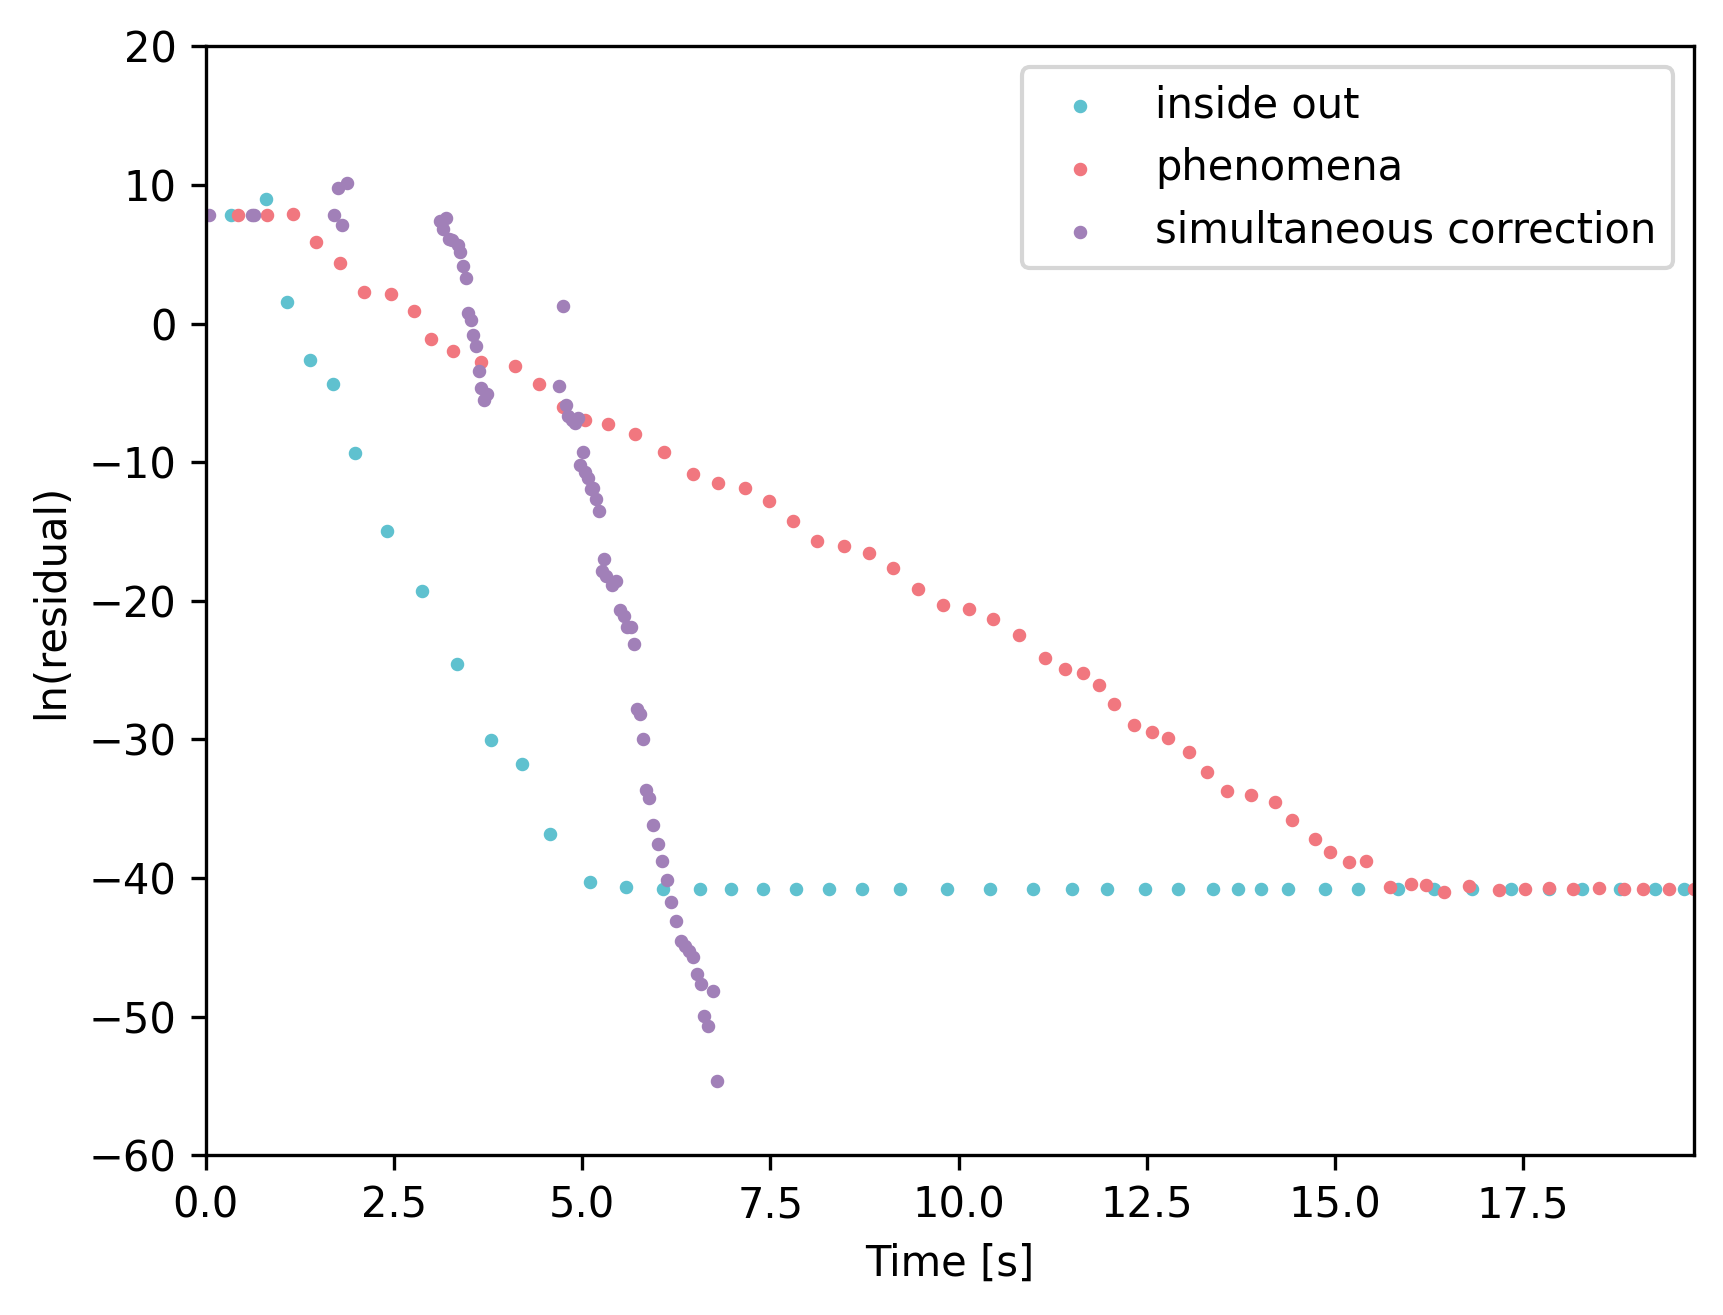

In [7]:
import matplotlib.pyplot as plt
feed = bst.Stream(
    ID='feed', phase='l', 
    T=329.54, P=372615, 
    Ethane=1.829e-07, Propane=0.0006211,
    **{'n-Butane': 1.296, 'n-Pentane': 44.89, 
       'n-Hexane': 74.35, 'n-Heptane': 30.86}, 
    Cyclohexane=9.647, Cycloheptane=0.1689, Benzene=81.36, 
    Toluene=0.02193, Hydrogen=2.426e-16,
    units='kmol/hr'
)
N_stages= 42
P_condenser = 351625
dP = 723.78
MESH = bst.MESHDistillation(
    'MESH',
    N_stages=N_stages, ins=[feed], feed_stages=[29],
    outs=['distillate', 'bottoms'],
    stage_specifications={
        0: ('Reflux', 0.857), 
        -1: ('Flow', 0.76) # Bottoms product flow rate as a fraction of column feed
    },
    LHK=('Cyclohexane', 'n-Heptane'),
    P=[P_condenser + i*dP for i in range(N_stages)],
    use_cache=True,
)
x0 = MESH.hot_start()
residual_profiles = []
algorithms =(
    'inside out',
    'phenomena', # Equivalent to Wang-Hanke's bubble point algorithm
    'simultaneous correction',
)
maxiter = 10000
maxtime = 20
residual_profiles = [
    MESH.convergence_analysis(
        maxiter, maxtime, x0=x0, algorithm=alg, 
        verbose=False,
        plot=False,
    ) for alg in algorithms
]
colors = bst.utils.GG_colors
profile_colors = [colors.blue, colors.red, colors.purple, colors.green]
yticks = [-60, -50, -40, -30, -20, -10, 0, 10, 20]
fig, ax = plt.subplots(1, 1)
tmax = 0
for alg, color, residual_profile in zip(algorithms, profile_colors, residual_profiles):
    tmax = max(tmax, residual_profile.time[-1])
    plt.scatter(
        residual_profile.time,
        residual_profile.log_residual,
        color=color.RGBn,
        label=alg or 'default',
        s=5,
    )
plt.ylim([yticks[0], yticks[-1]])
plt.xlim([0, tmax])   
plt.yticks(yticks)
plt.xlabel('Time [s]')
plt.ylabel('ln(residual)')
plt.legend()
plt.show()

The inside-out method is the most robust for this test case with many chemicals and stages. 

## Future tutorials

Intermolecular forces within mixtures may lead to azeotropes which make vapor-liquid separations more challenging. A classic example is the separation of bioethanol from beer; a single distillation column may be infeasible due to the azeotrope. Using our knowledge on thermodynamics, however, we can find ways to either break or shift the azeotrope to achieve a feasible distillation-based separation scheme. In future examples, we we will show how pressure-swing distillation and extractive distillation can shift or break an  azeotrope to allow for the separation of azeotropic mixtures.